![](https://miro.medium.com/max/1050/1*kU_mPtwcjfEUSkSflUikxw.jpeg)

**Churn rate is the percentage of subscribers to a service that discontinue their subscription to that service in a given time period. With growing pressure from competition and government mandates improving retention rates of profitable customers has become an increasingly urgent to telecom service providers.**

# Topics Covered: 

1. EDA
2. Outliers Detection
3. Checking Correlation
4. PCA
5. Pipeline
6. Logistic Algorithm
7. Random Forest Classifier
8. Naive Bayes

In [ ]:
#import libraries
import os
import numpy as np
import pandas as pd
from scipy import stats

#import visualization libs
import matplotlib.pyplot as plt
import seaborn as sns

#import preprocessing libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV

#import dimensions related libraries
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline

#import algos
from sklearn.linear_model import LogisticRegression,SGDClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

#import error metrics
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve


In [ ]:
#get the path of our dataset
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
#read and analyze the data
data = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

print("Shape",data.shape)

print("Info", data.info())

data.head()

In [ ]:
#check the null values
((data.isnull().sum()*100)/len(data)).sort_values(ascending=False)

In [ ]:
#check the unique values
data.nunique()

# 1. EDA

In [ ]:
#Lets do some EDA
churn = data[data.Churn == 'Yes']
non_churn = data[data.Churn == 'No']

In [ ]:
#Churn Vs Gender

sns.set_palette(sns.color_palette('muted', 7))
plt.figure(figsize=(8,4))
sns.countplot('gender', data=data, hue='Churn')

In [ ]:
#Churn Vs SeniorCitizen

sns.set_palette(sns.color_palette('hls', 7))
plt.figure(figsize=(8,4))
sns.countplot('SeniorCitizen', data=data, hue='Churn')

In [ ]:
#tenure relation with churn

sns.set_palette(sns.color_palette('Blues_d', 2))
sns.boxplot(x='Churn' ,y='tenure', data=data)

#seems most of the people who left service had less tenure

In [ ]:
sns.set_palette(sns.color_palette('RdBu', 2))

sns.boxplot(x='Churn',y='MonthlyCharges',data=data)

From the above graph, we can see that the people who left had higher monthly charges.

In [ ]:
#First convert the object column into type float
data['TotalCharges'] = data['TotalCharges'].replace('[^\d.]', '', regex = True).replace('',np.nan).astype(float)
sns.boxplot(x='Churn',y='TotalCharges',data=data)

Total charges were less as compared to overall population for the people who left but there are multiple outliers.

In [ ]:
sns.kdeplot(data[data['Churn'] == 'No']['TotalCharges'], label= 'Churn: No')
sns.kdeplot(data[data['Churn'] == 'Yes']['TotalCharges'], label= 'Churn: Yes')

In [ ]:
sns.kdeplot(data[data['Churn'] == 'No']['tenure'], label= 'Churn: No')
sns.kdeplot(data[data['Churn'] == 'Yes']['tenure'], label= 'Churn: Yes')

In [ ]:
#now check the numeric columns and check the distribution of data
t= (data.dtypes != 'object')
#now convert the data into list
num_cols = list(t[t].index)
num_cols

In [ ]:
#Balance the data for numeric columns after EDA

sns.set_palette(sns.color_palette('muted', 1))
sns.distplot(data['tenure'], bins=20, hist=True,label='tenure')

In [ ]:
sns.distplot(data['MonthlyCharges'], bins=20, hist=True,label='MonthlyCharges')

In [ ]:
sns.distplot(data['TotalCharges'], bins=10, hist=True,label='TotalCharges')

In [ ]:
sns.set_palette(sns.color_palette('hls', 4))
sns.catplot(y="Churn", x="MonthlyCharges", row="PaymentMethod", kind="box", data=data, height=2, aspect=4, orient='h')

**Lets check for the outliers, there are many methods but we will go for IQR and Z-Scores and will see the difference**

In [ ]:
sns.boxplot(x=data['MonthlyCharges'])


In [ ]:
sns.boxplot(x=data['TotalCharges'])

In [ ]:
#Tenure V/s Monthly Charges

sns.set(style="ticks")
x = data['tenure']
y = data['MonthlyCharges']
sns.jointplot(x, y, kind="hex", color="#4CB391")

In [ ]:
# Show the joint distribution using kernel density estimation

g = sns.jointplot(x, y, kind="kde",
                  height=4, space=0)

In [ ]:
sns.set(style="darkgrid")
g = sns.jointplot("TotalCharges", "tenure", 
                   data=data, kind="reg",
                   color="m", height=6)

# Few EDA Conclusions:

1. Gender is not a clear indicator of Churn. 
2. Senior Citizens have a higher Churn rate as compared to other. 
3. Most of the people who left, had left in the initial 24 months with a mean of around 11 months.
4. Monthly charge is a main reason of Churn. 
5. People having extremely high monthly charges have also left the services.
6. People having online payment mode are more likely to Churn.

# 2. Outliers Detection

> **First Approach: Using IQR** -- The IQR is calculated as the difference between the 75th and the 25th percentiles of the data.

In [ ]:
#lets calculate the IQR
Q1 = data['TotalCharges'].quantile(0.25)
Q3 = data['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

In [ ]:
print((data['TotalCharges'] < (Q1 - 1.5 * IQR)) |(data['TotalCharges'] > (Q3 + 1.5 * IQR)))

In [ ]:
totalcharge_out = ((data['TotalCharges'] < (Q1 - 1.5 * IQR)) |(data['TotalCharges'] > (Q3 + 1.5 * IQR)))
TotalCharges = data['TotalCharges'][~totalcharge_out]
TotalCharges.shape

**Second Approach: Using ZScore**: Technically it's a measure of how many standard deviations below or above the population mean a raw score is, which in return gives you an idea of how far from the mean a data point is.

In [ ]:
#Lets check with zscore
z = np.abs(stats.zscore(data['TotalCharges']))
print(z)

In [ ]:
threshold = 3
print(np.where(z > 3))

So no outliers are there for TotalCharges

# 3. Checking Correlation

In [ ]:
#Create a heatmap
plt.figure(figsize=(15, 10))
data.drop(['customerID'], axis=1, inplace=True)
# We will get the numeric representation of the object columns to numeric ones by applying pd.factorize.
corr = data.apply(lambda x: pd.factorize(x)[0]).corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu", annot=True)



#lets first use the pearson coefficient to check the correlation
print(data.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1))  

#check the correlation between columns which is greater than 0.95
corr = data.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.95:
            if columns[j]:
                columns[j] = False
                
selected_columns = corr.columns[columns]
corr = corr[selected_columns]
corr.head()

**Convert the object columns into numerical** by applying encoding.

In [ ]:
#now check the object columns
ob= (data.dtypes == 'object')
#now convert the data into list
obj_cols = list(ob[ob].index)
print("List of Object columns",obj_cols)
print()
print("Number of Unique Values\n",data.nunique())

As we can see that we have less unique values for object columns. Lets use get_dummies to convert the values

> **StratifiedKFold**: StratifiedKFold is a variation of KFold and ensure each fold is a good representative of the whole. 

* First, StratifiedKFold shuffles your data, after that splits the data into n_splits parts. Now, it will use each part as a test set. Note that it only and always shuffles data one time before splitting.
* With shuffle = True, the data is shuffled by your random_state. Otherwise, the data is shuffled by np.random (as default).

In [ ]:
#lets split the data into train and validation set
data_x, data_y = data.drop(columns = 'Churn'), data['Churn']
skf = StratifiedKFold(n_splits=20, shuffle=True, random_state= 142)
for train_index, val_index in skf.split(data_x,data_y):
    train_x, val_x = data_x.iloc[train_index], data_x.iloc[val_index]
    train_y, val_y = data_y.iloc[train_index], data_y.iloc[val_index]
    
train_x.shape, val_x.shape    

In [ ]:
train_x = pd.get_dummies(train_x)
print(train_x.head())
val_x = pd.get_dummies(val_x)
val_x.head()

# 4. PCA and Pipeline

Before starting on algorithms, lets understand some theory about these topics:

**PCA:** Principal Component Analysis is used basically for dimensionality reduction. The idea of PCA is simple — reduce the number of variables of a data set, while preserving as much information as possible.
Steps for PCA:
* Standardization: Standardize the range of the continuous initial variables so that each one of them contributes equally to the analysis. Otherwise the variables with larger ranges will dominate the ones with smaller range.
* Covariance matrix calculation: The covariance matrix is a p × p symmetric matrix (where p is the number of dimensions) which tells us how the variables are correlated to each other. The covariance of a variable with itself is its variance (Cov(a,a)=Var(a)) and also the covariance is commutative (Cov(a,b)=Cov(b,a)). 
* Compute the Eigenvectors and Eigenvalues of the Covriance Matrix to identify the PRINCIPAL COMPONENTS: The eigenvectors of the Covariance matrix are actually the directions of the axes where there is the most variance(most information) and that we call Principal Components. And eigenvalues are simply the coefficients attached to eigenvectors, which give the amount of variance carried in each Principal Component.
* Feature Vector: Choose whether to keep all these components or discard those of lesser significance (of low eigenvalues), and form with the remaining ones a matrix of vectors that we call Feature vector.
* Recast the data along the PC axes: The aim is to use the feature vector formed using the eigenvectors of the covariance matrix, to reorient the data from the original axes to the ones represented by the principal components (hence the name Principal Components Analysis).

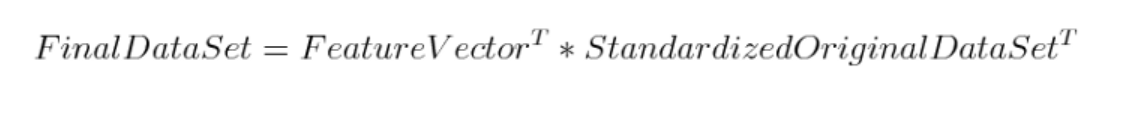

> Geometrically speaking, principal components represent the directions of the data that explain a maximal amount of variance, that is to say, the lines that capture most information of the data. The relationship between variance and information here, is that, the larger the variance carried by a line, the larger the dispersion of the data points along it, and the larger the dispersion along a line, the more the information it has. To put all this simply, just think of principal components as new axes that provide the best angle to see and evaluate the data, so that the differences between the observations are better visible.

> An important thing to realize here is that, the principal components are less interpretable and don’t have any real meaning since they are constructed as linear combinations of the initial variables.

![](https://builtin.com/sites/default/files/inline-images/Principal%20Component%20Analysis%20second%20principal.gif)

Pipeline: There are a lot of steps which we need to perform for the ML model. By using Pipeline, we will just tied them together and produce the results. 

Logistic Regression: It is linear model which is used for classification problems. It makes use of the sigmoid function which returns the value between 0 and 1. Based on the threshold, the class is determined for that dependent variable. 

In [ ]:
#Lets first start with Logistic Regression
logReg = LogisticRegression()
sc = StandardScaler()
pca = PCA()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a logistic regression on the data.
pipe = Pipeline(steps=[('sc', sc),
                       ('pca', pca),
                       ('logistic', logReg)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,train_x.shape[1]+1,1))
# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)
# Create a list of options for the regularization penalty
penalty = ['l2']
# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                  logistic__C=C,
                  logistic__penalty=penalty)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

In [ ]:
train_x = train_x.reset_index()
val_x = val_x.reset_index()

#np.nan_to_num(train_x)
train_x = train_x.fillna(train_x.mean())
val_x = val_x.fillna(val_x.mean())
print(np.all(np.isfinite(train_x)))
print(np.any(np.isnan(train_x)))
print(train_x.isnull().sum())


In [ ]:
clf.fit(train_x,train_y)

# View The Best Parameters
print('Best Penalty:', clf.best_estimator_.get_params()['logistic__penalty'])
print('Best C:', clf.best_estimator_.get_params()['logistic__C'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print();print(clf.best_estimator_.get_params()['logistic'])

clf_pred = clf.best_estimator_.predict(val_x)

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, val_x, val_y, cv=4, n_jobs=-1)
print(CV_Result)
print(CV_Result.mean())
print(CV_Result.std())

We will implement the confusion matrix but before that, lets understand some theory about this: 

**Confusion Matrix** : A confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. There are 4 possible outcomes:

* True Positives(TP) : The cases in which we predicted YES and the actual output was also YES.
* True Negatives(TN) : The cases in which we predicted NO and the actual output was also NO.
* False Positives(FP) : The cases in which we predicted YES whereas the actual output was NO.
* False Negatives(FN) : The cases in which we predicted NO whereas the actual output was YES.

![](https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg?w=748)

**Accuracy Score** : Accuracy or classification accuracy tells the number of correct predictions made by the model. It is the ratio of the number of correct predictions to the total number of input samples. For binary classification the accuracy can be defined as:

Accuracy = (TP + TN) / (TP + TN + FP + FN)

In [ ]:
# Check the accuracy of the model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix( val_y, clf_pred)
print(cm)

# Lets check classification report also 
from sklearn.metrics import classification_report
cr = classification_report( val_y, clf_pred)
print(cr)

![](https://miro.medium.com/max/623/1*uR09zTlPgIj5PvMYJZScVg.png)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

le = LabelEncoder()
le_val = le.fit(val_y)
le_val = le.transform(val_y)
clf_pred = le.transform(clf_pred)

# Now we will check ROC curve
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
print('AUC: %.2f'% roc_auc_score(le_val, clf_pred))

# plot the curve
fpr, tpr, thresholds = roc_curve(le_val, clf_pred)
plot_roc_curve(fpr, tpr)

# Random Forest Classifier

Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting.

It technically is an ensemble method (based on the divide-and-conquer approach) of decision trees generated on a randomly split dataset. This collection of decision tree classifiers is also known as the forest. The individual decision trees are generated using an attribute selection indicator such as information gain, gain ratio, and Gini index for each attribute. Each tree depends on an independent random sample. In a classification problem, each tree votes and the most popular class is chosen as the final result.

**Working**

1. Select random samples from a given dataset.
2. Construct a decision tree for each sample and get a prediction result from each decision tree.
3. Perform a vote for each predicted result.
4. Select the prediction result with the most votes as the final prediction.

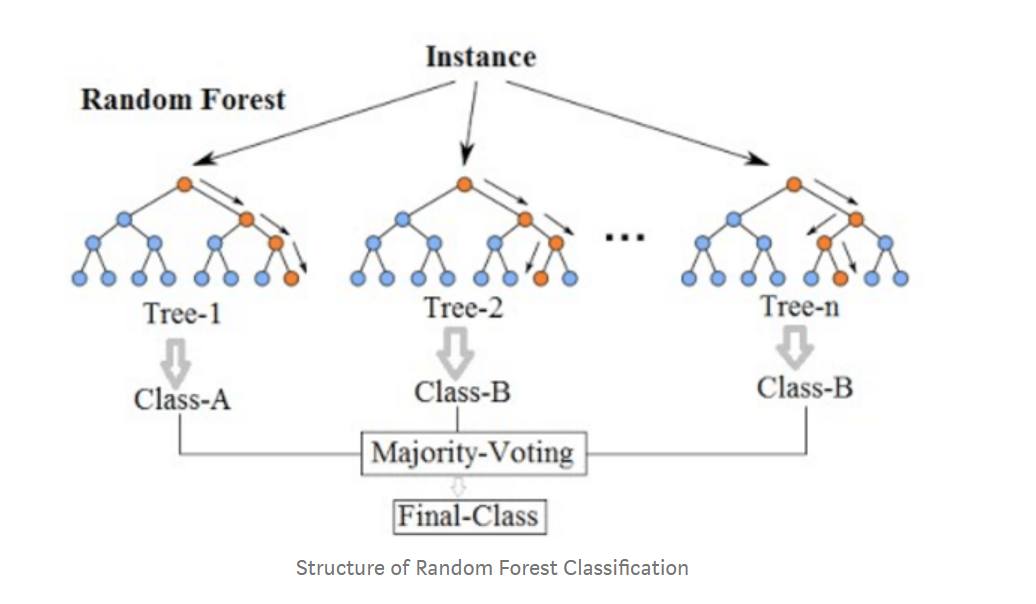

Advantages: 
1. It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
2. Random forests can also handle missing values. There are two ways to handle these: using median values to replace continuous variables, and computing the proximity-weighted average of missing values.
3. Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.

**Finding important features:**

Random forest uses gini importance or mean decrease in impurity (MDI) to calculate the importance of each feature. Gini importance is also known as the total decrease in node impurity. This is how much the model fit or accuracy decreases when you drop a variable. The larger the decrease, the more significant the variable is. Here, the mean decrease is a significant parameter for variable selection. The Gini index can describe the overall explanatory power of the variables.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc_model=RandomForestClassifier(n_estimators=200, criterion='entropy', random_state=42)

rfc_model.fit(train_x,train_y)

rfc_pred = rfc_model.predict(val_x)

In [ ]:
rfc_pred = le.transform(rfc_pred)

print('AUC: %.2f'% roc_auc_score(le_val, rfc_pred))

# plot the curve
fpr, tpr, thresholds = roc_curve(le_val, rfc_pred)
plot_roc_curve(fpr, tpr)

We can see that the AUC is around 0.7 which is not a great value for our accuracy. 

So let's try with some other algorithm. We will try with Naive Bayes

# Naive Bayes

Naive Bayes is a statistical classification technique based on Bayes Theorem. Naive Bayes classifiers have high accuracy and speed on large datasets.

Naive Bayes classifier assumes that the effect of a particular feature in a class is independent of other features.Even if these features are interdependent, these features are still considered independently. This assumption simplifies computation, and that's why it is considered as naive. This assumption is called class conditional independence.

![](https://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1543836882/image_3_ijznzs.png)

* P(h): the probability of hypothesis h being true (regardless of the data). This is known as the prior probability of h.
* P(D): the probability of the data (regardless of the hypothesis). This is known as the prior probability.
* P(h|D): the probability of hypothesis h given the data D. This is known as posterior probability.
* P(D|h): the probability of data d given that the hypothesis h was true. This is known as posterior probability.

**Working of Naive Bayes**:

* Step 1: Calculate the prior probability for given class labels
* Step 2: Find Likelihood(conditional) probability with each attribute for each class
* Step 3: Multiply same class conditional probability. 
* Step 4: Multiply prior probability with Step 3 probability.
* Step 5: See which class has a higher probability, higher probability class belongs to given input set step.

In [ ]:
#Import Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(train_x,train_y)

gnb_pred = gnb_model.predict(val_x)

gnb_pred = le.transform(gnb_pred)

# Now check the accuracy of the model
print('AUC: %.2f'% roc_auc_score(le_val, gnb_pred))

# plot the curve
fpr, tpr, thresholds = roc_curve(le_val, gnb_pred)
plot_roc_curve(fpr, tpr)

So we can say that on this data Naive Bayes is performing better than other 2 algorithms. 

* Reference: https://www.kaggle.com/jsaguiar/exploratory-analysis-with-seaborn
* PCA : https://builtin.com/data-science/step-step-explanation-principal-component-analysis
* Naive Bayes: https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn